# Informações úteis resgatadas:

+ [Python Raiz: flatten lists](https://stackoverflow.com/questions/952914/how-to-make-a-flat-list-out-of-list-of-lists)
+ Numpy: encontrar linha mais próxima de uma matriz dado o input
    + [Matching a row](https://stackoverflow.com/questions/40382384/finding-a-matching-row-in-a-numpy-matrix)
    + [Matching a row 2](https://stackoverflow.com/questions/25823608/find-matching-rows-in-2-dimensional-numpy-array)
    + [Matching a row 3](https://stackoverflow.com/questions/18927475/numpy-array-get-row-index-searching-by-a-row)
    + [Nearest value that is greater](https://stackoverflow.com/questions/17118350/how-to-find-nearest-value-that-is-greater-in-numpy-array)
    + [Finding elements approx equal - prelim](https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array)
    + [Finding elements approx equal - isclose](https://stackoverflow.com/questions/49191460/numpy-check-where-elements-of-two-arrays-are-approximately-equal)
+ Numba:
 + [Pass function as argument](https://stackoverflow.com/questions/59573365/using-a-function-object-as-an-argument-for-numba-njit-function)
+ MPL:
 + [Publication quality plots](https://python4astronomers.github.io/plotting/publication.html)
 + [Circle/ellipse](https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/axis_equal_demo.html)
 
 

## Utilidades:
+ O Numba não aceita o np.isclose, o que foi um problema. Tive de alterar o programa de localização de parâmetro de arco s comparando o ponto de colisão com um ponto na matriz de parametrização numérica. As modificações essenciais foram:
 * Seja all_points a matriz de colunas x,y (pontos de fato da parametrização), com data_in uma matriz de três colunas da parametrização: x,y,s.
 * Como não pude usar np.isclose, tirei np.abs(all_points - r_comparação). Depois disso, como quero a linha da matriz 
   all_points que melhor se aproxime de r_comparação, precisei tirar o np.linalg.norm no eixo 1 (restando apenas uma matriz coluna onde cada elemento é a distância de um ponto da parametrização numérica ao dado ponto r_comparação, que é o ponto de colisão)
 * Em seguida, foi suficiente extrair o i = argmin(), o índice da linha tal que o (x,y) dessa linha tivesse a menor distância ao ponto de colisão. Esse índice é tal que ``data_in[i,:]`` fornece (x_localizado, y_localizado, s).

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numba
import scipy.optimize
import os
plt.rc('font', family='serif', size=12)

In [3]:
@numba.njit('f8(f8[:],f8[:,:])')
def mapeia_arco(r,data_in):
    '''
    Entrada:
        data_in é um array de 3 colunas (x,y,t) proveniente de uma parametrização numérica.
        r é um vetor de 2 elementos (flat array)
    
    Saída:
        s: parâmetro de arco no dado ponto de colisão r
    
    '''
    # Basta calcular a distância do ponto de colisão r a todos os pontos (x,y) presentes na parametrização numérica.
#     Exemplo: data_in = [[1,1],
#                         [1,-1],
#                         [-1,1],
#                         [-1,-1]]
    # Se r = [1,-1], teremos data_in-r =
#                         [[0,2],
#                         [0,0],
#                         [-2,2],
#                         [-2,0]]    
    # De imediato, vemos que a linha 2 de data_in é que melhor se aproxima de r. O procedimento geral é o seguinte:
    # tomamos data_in-r e então calculamos a norma de cada linha. A linha que tiver a menor norma certamente é a que melhor
    # representa o ponto r. Extrai-se o índice dessa linha com np.argmin.
    
    dist_prelim = data_in[:,:2]-r
    dist_abs = np.sqrt(dist_prelim[:,0]**2 + dist_prelim[:,1]**2)
    melhor_ind = dist_abs.argmin()
    
    s = data_in[melhor_ind, 4] #extrai o tempo t de parametrização
    return s/data_in[-1,4] # Retorna s normalizado entre 0 e 1
    
    

In [4]:
@numba.njit('Tuple((b1,f8))(f8[:],f8,f8)')
def verifica(r,a,b):
    """
    Função que averigua se extrapolou a região útil da função.
    Entrada:
        r (float64[:]): o vetor posição no dado ponto
        a (float64): semieixo maior
        b (float64): semieixo menor
    Saída:
        bool (True ou False): True se ultrapassar, False do contrário.
        err (float64): Erro absoluto cometido
    """
    
    x,y = r
    err = ((x/a)**2 + (y/b)**2) - 1
    
    if err > 0:
        return True, np.abs(err)
    else:
        return False, np.abs(err)
    

In [5]:
@numba.njit('Tuple((f8[:],f8))(f8[:],f8[:],f8,f8,f8)')
def corrigir(r_antes,v_antes, a, b, dt):
    """
    Função que corrige a posição da colisão.
    
    Variveis internas:
        prec: precisão (10^-6)
    
    Entrada: 
        r_antes(float64[:]): posição inicial mais próxima da colisão
        v_antes(float64[:]): velocidade antes da colisão
        a(float64): semieixo maior
        b(float64): semieixo menor
        dt(float64): passo de integração
    
    Saída:
        r_colisão(float64[:]): vetor posição da colisão
        error(float64): erro cometido na localização do ponto de colisão
    """
    
    prec = 1e-8
    #print('prec =',prec)
    while True:
        dt = dt/10
        
        extrapolado, erro_antes = verifica(r_antes,a,b)
        
        while True:
            r_novo = r_antes + v_antes*dt
            extrapolado,erro_novo = verifica(r_novo,a,b)
            
            if extrapolado==True:
                break
            
            r_antes = r_novo
            erro_antes = erro_novo
            
            
        r_colisao = r_antes
        error = erro_antes
        
        if error < prec:
            #print(error)
            break
            
    return r_colisao, error

In [6]:
@numba.njit('f8[:](f8[:],f8[:],f8,f8)')
def vel_refletida(r_col, v_antes,a ,b):
    """
    Função que calcula a velocidade após uma reflexão especular.
    
    Entrada: r_col (float64[:])
             v_antes (float64[:])
             a (float64)
             b (float64)
    
    Saída:   v (float64[:])
    """
    x,y = r_col
    nabla = np.array([2*x/a**2, 2*y/b**2])
    
    normal = nabla/np.linalg.norm(nabla)
    paralelo = np.array([-normal[1], normal[0]])
    
#     v_refletida = -(np.dot(v_antes, normal) * normal) + (np.dot(v_antes, paralelo)) * paralelo
    v_refletida = - (v_antes*normal).sum() * normal + ((v_antes* paralelo).sum()) * paralelo
    
    return v_refletida

In [7]:
@numba.njit('f8[:](f8[:],f8,f8)')
def par_vec(r,a,b):
    x,y = r
    u = np.array([-2*y/b**2, 2*x/a**2])
    u = u/np.linalg.norm(u)
    return u

In [8]:
@numba.njit()
def numeric_parameterization(r0,dt,a,b):
    
    """
    Entrada:
        r0: f8[:]
        dt: f8
        a: f8
        b: f8
    
    Saída:
        full_parameterization: array python->np f8[:,:] (5 colunas)
    
    
    """
    
    
    full_parameterization = []
    
    t = 0
    r = r0

    while True:
        r_anterior = r
        u = par_vec(r,a,b)
        x,y = r
        ux,uy = u
        param_row = [x,y,ux,uy,t]
        full_parameterization.append(param_row)
        
        r = r+u*dt
        t = t+dt
        
        # Verificação para conclusão da curva fechada:
        if t/dt > 100:
            if np.linalg.norm(np.abs(r-r0)) < 1e-3:
                break
            else:
                if t/dt > 1e6:
                    break
    return np.array(full_parameterization)
        
        

In [9]:
@numba.njit('Tuple((f8[:,:],f8[:,:]))(i8,f8,f8[:],f8[:],f8,f8,f8[:,:])')
def simula(Ncol,dt,v0,r0,a,b, param_data):
    
    """
    Entrada:
        Ncol: i8
        dt:   f8
        v0:   f8[:]
        r0:   f8[:]
        a:    f8
        b:    f8
        param_data: f8[:,:] (3 colunas: x,y,s)
    
    Saída:
        pos_vel: f8[:,:]
        fase: f8[:,:]
    """
    
    pos_vel = []
    fase = []
    r_a = r0
    v = v0
    t = 0.
    cols=0
    
#     List comprehension e "flattening":
#         Sejam a = [1,2], b = [3,4] e c = [5]. O objetivo é gerar d = [1,2,3,4,5], ou seja, dar um
#         flatten geral em [a,b,c] = [[1,2], [3,4], [5]]. Em loops explícitos, isso é bem simples:
            
#             lista = []
#             for x in (a,b,c):
#                 for y in x:
#                     lista.append(y)
        
#         Convertendo para list comprehension:
            
#             [y for x in (a,b,c) for y in x]
    
    xt,yt = r_a
    vxt,vyt = v
    temp_array = [xt,yt,vxt,vyt,t]
    pos_vel.append(temp_array)
    
    while True:
        
        t = t+dt
        r = r_a + v*dt
        
        explodiu, _ = verifica(r,a,b)
        if explodiu:
            r, _ = corrigir(r_a, v, a, b, dt)
            v = vel_refletida(r,v,a,b)
            u = par_vec(r,a,b)
            p = (v*u).sum()/np.linalg.norm(v)
            s = mapeia_arco(r, param_data)
            
            fase.append([s,p])
            
            cols+= 1
            if cols >= Ncol:
                break
        
        xt,yt = r
        vxt,vyt = v
        temp_array = [xt,yt,vxt,vyt,t]
        pos_vel.append(temp_array)

        
        r_a = r
    
    return np.array(pos_vel), np.array(fase)
    

In [4]:
def calcula_raio(N):
    assert N>4
    return np.tan(np.pi/2 - 2*np.pi/N)/( np.tan(np.pi/2 - 2*np.pi/N) + np.tan(np.pi/N)  )

In [9]:
calcula_raio(14)

0.9009688679024191

In [12]:
def c(a,b):
    return np.sqrt(a**2-b**2)

# Célula de simulação

In [13]:
def full_sim(Ncol,a,b,r0):
    # Num_Parametr
    def f(x,y,a,b):
        return x**2/a**2+y**2/b**2-1
    x0 = scipy.optimize.root(f,a,args=(0,a,b)).x[0]
    pos0 = np.array([x0,0])
    dt=1e-4
    full_param = %time numeric_parameterization(pos0,dt,a,b)
    
    # Num_Simul.
    v0 = np.array([0,1.])
    dt=1e-3
    pos_vel, fase = %time simula(Ncol,dt,v0,r0,a,b, full_param)
    
    return full_param, pos_vel, fase
    

In [14]:
def full_plots(full_param,pos_vel,fase,local,nome,titulos):
    path_xy = os.path.join(local,'xy_'+nome) + '.jpg'
    path_fase = os.path.join(local,'fase_'+nome) + '.jpg'
    
    #Plot (x,y):
    fig,ax = plt.subplots(figsize=(5,5))
    ax.plot(full_param[:,0], full_param[:,1], 'k-')
    ax.plot(pos_vel[:,0], pos_vel[:,1], 'r-')
    # plt.axis('scaled')
    ax.set_aspect('equal', 'box')
    ax.set(xlabel=r'$x$ [u.d.]',
           ylabel=r'$y$ [u.d.]',
           title=titulos[0],
           yticks = np.linspace(-1,1,5)
          )
    fig.tight_layout()
    fig.savefig(path_xy,dpi=300)
#     plt.show()
    plt.close()
    
    
    # Plot (s,p)
    fig2,ax2 = plt.subplots(figsize=(5,5))
    ax2.plot(fase[:,0], fase[:,1], 'ko')
    # plt.axis('scaled')
#     ax2.set_aspect('equal', 'box')
    ax2.set(xlabel=r'$S$ [em termos de $L$]',
            ylabel=r'$p$ [adimensional]',
            title=titulos[1],
            ylim=(-1,1)
          )
#     fig2.tight_layout()
    fig2.savefig(path_fase,dpi=300)
#     plt.show()
    plt.close()

In [15]:
def simple_plots(full_param,pos_vel, fase):
    
    #Plot (x,y):
    fig,ax = plt.subplots(figsize=(5,5))
    ax.plot(full_param[:,0], full_param[:,1], 'k-')
    ax.plot(pos_vel[:,0], pos_vel[:,1], 'r-')
    # plt.axis('scaled')
    ax.set_aspect('equal', 'box')
    ax.set(xlabel=r'$x$ [u.d.]',
           ylabel=r'$y$ [u.d.]',
           title=r'Plot $(x,y)$',
           yticks = np.linspace(-1,1,5)
          )
    fig.tight_layout()
    plt.show()
    
    
    # Plot (s,p)
    fig2,ax2 = plt.subplots(figsize=(5,5))
    ax2.plot(fase[:,0], fase[:,1], 'ko')
    # plt.axis('scaled')
#     ax2.set_aspect('equal', 'box')
    ax2.set(xlabel=r'$S$ [em termos de $L$]',
            ylabel=r'$p$ [adimensional]',
            title=r'Seção de Poincaré $(s,p)$',
            ylim=(-1,1)
          )
#     fig2.tight_layout()
    plt.show()

Wall time: 125 ms
Wall time: 440 ms


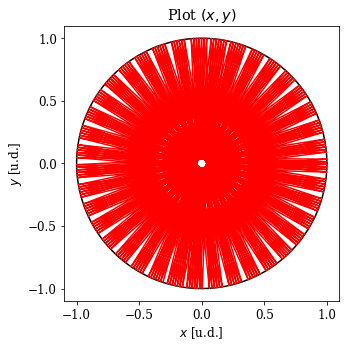

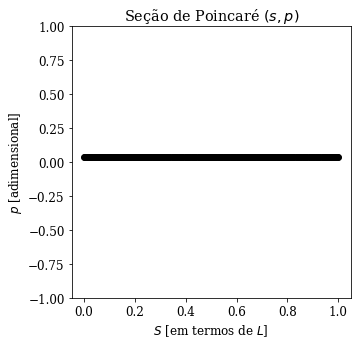

In [40]:
a=1.
b=1.
x0=0.04
Ncol=240

full_param,pos_vel,fase = full_sim(Ncol,a,b,np.array([x0,0]))
simple_plots(full_param, pos_vel, fase)
# full_plots(full_param, pos_vel, fase,
#            'pres_img/graf_x0',
#            'x0_{:.2f}'.format(x0),
#            [r'Posição no plano $(x,y)$, $x_0$ = {:.2f}'.format(x0),
#            r'Seção de Poincaré $(S,p)$, $x_0$ = {:.2f}'.format(x0)])

In [32]:
Ncol = 85
a=1.
b=1.

# for N in np.arange(5,15):
#     nome = 'N_{}'.format(N)
#     local='pres_img/graf_N'
#     full_param,pos_vel,fase = full_sim(Ncol,a,b,np.array([calcula_raio(N),0]))
    
#     if N%2==0:
#         alpha = r'$\pi /{}$'.format(int(N/2))
#     else:
#         alpha = r'$2 \pi /{}$'.format(N)
        
#     titulo_xy = r'Posição no plano $(x,y)$, $\alpha$ = {}'.format(alpha)
#     titulo_fase = r'Seção de Poincaré $(S,p)$, $\alpha$ = {}'.format(alpha)
#     titulos = [titulo_xy, titulo_fase]
#     full_plots(full_param, pos_vel, fase,local,nome,titulos)
    
for x0 in np.linspace(0.1,0.8,6):
    nome = 'x0_{:.2f}'.format(x0)
    local='pres_img/graf_x0'
    full_param,pos_vel,fase = full_sim(Ncol,a,b,np.array([x0,0]))
    
    titulo_xy = r'Posição no plano $(x,y)$, $x_0$ = {:.2f}'.format(x0)
    titulo_fase = r'Seção de Poincaré $(S,p)$, $x_0$ = {:.2f}'.format(x0)
    titulos = [titulo_xy, titulo_fase]
    full_plots(full_param, pos_vel, fase,local,nome,titulos)

Wall time: 133 ms
Wall time: 165 ms
Wall time: 110 ms
Wall time: 162 ms
Wall time: 118 ms
Wall time: 177 ms
Wall time: 113 ms
Wall time: 160 ms
Wall time: 122 ms
Wall time: 165 ms
Wall time: 112 ms
Wall time: 131 ms


In [90]:
np.rad2deg(np.arccos(fase[:,1][0]))

67.66631733375193

# Calculando a seção de Poincaré $(s,p)$

Wall time: 242 ms
Wall time: 163 ms
Wall time: 134 ms
Wall time: 136 ms
Wall time: 123 ms
Wall time: 124 ms
Wall time: 118 ms
Wall time: 127 ms
Wall time: 151 ms
Wall time: 149 ms
Wall time: 149 ms
Wall time: 128 ms
Wall time: 125 ms
Wall time: 115 ms
Wall time: 117 ms
Wall time: 115 ms
Wall time: 128 ms
Wall time: 134 ms
Wall time: 157 ms
Wall time: 205 ms
Wall time: 113 ms
Wall time: 118 ms
Wall time: 111 ms
Wall time: 116 ms
Wall time: 113 ms
Wall time: 138 ms
Wall time: 139 ms
Wall time: 142 ms
Wall time: 125 ms
Wall time: 113 ms
Wall time: 120 ms
Wall time: 140 ms
Wall time: 144 ms
Wall time: 136 ms
Wall time: 118 ms
Wall time: 143 ms
Wall time: 146 ms
Wall time: 125 ms
Wall time: 112 ms
Wall time: 133 ms
Wall time: 146 ms
Wall time: 136 ms
Wall time: 111 ms
Wall time: 117 ms
Wall time: 113 ms
Wall time: 118 ms
Wall time: 113 ms
Wall time: 141 ms
Wall time: 141 ms
Wall time: 143 ms


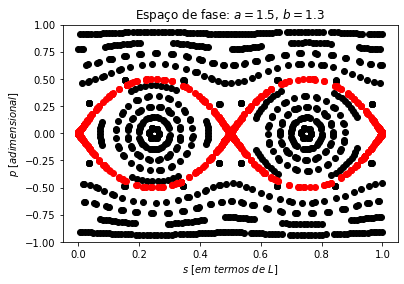

Wall time: 7.41 s


In [41]:
%%time

xsep = c(a,b)

fig, ax = plt.subplots();
for x0 in np.linspace(-1.4,1.4,20):
    r0 = np.array([x0, 0.])
    v0 = np.array([0., 1.])
    dt = 1e-3
    Tsim = 100
    %time pos_vel, fase = simula(Tsim,dt,v0,r0,a,b, full_param)
    ax.plot(fase[:,0], fase[:,1],'ko');

for x0 in np.linspace(xsep-0.0001,xsep+0.0001,15):
    r0 = np.array([x0, 0])
    v0 = np.array([0., 1.])
    dt = 1e-3
    Tsim = 100
    %time pos_vel, fase = simula(Tsim,dt,v0,r0,a,b, full_param)
    ax.plot(fase[:,0], fase[:,1],'ro');

for x0 in np.linspace(-xsep-0.0001,-xsep+0.0001,15):
    r0 = np.array([x0, 0])
    v0 = np.array([0., 1.])
    dt = 1e-3
    Tsim = 100
    %time pos_vel, fase = simula(Tsim,dt,v0,r0,a,b, full_param)
    ax.plot(fase[:,0], fase[:,1],'ro');


ax.grid(False)
ax.set(ylim=(-1,1),
       xlabel=r'$s \ [em \ termos \ de \ L]$',
       ylabel=r'$p \ [adimensional]$',
       title=r'Espaço de fase: $a=1.5$, $b = 1.3$')
plt.show()
fig.savefig('./imagens/bilhar_elíptico.jpg', dpi=300)